# Uses For PCA Other Than Dimensionality Reduction Part I
## Decorrelation, Factor Discovery, and Noise Modeling

Principal Component Analysis (PCA) is frequently applied in machine learning as a sort of black box dimensionality reduction technique. However with a deeper understanding of what PCA is and what it does we can use it for all manner of other tasks e.g.

* Decorrelating Variables
* Semantic Factor Discovery
* Empirical Noise Modeling
* Missing Data Imputation 
* Example Generation 
* Anomaly Detection
* Patchwise Modeling
* Noise Reduction

We will demonstrate how to use PCA for these purposes on an example face dataset. In this first post we will handle up till empirical noise modeling and handle the rest in subsequent parts.

<!-- TEASER_END -->

PCA is what is what is called a "low rank matrix factorization". That is to say if we have a matrix of observations $X$ which in which we have N rows and m feature columns we want to find a good approximation to X call it $\hat{X}$ which can be written as a product of a tall skinny N by k matrix call it W and a short fat k by m matrix call it H.

$$
X \approx \hat{X} = W~H
$$

If we pick the W and H which minimize the sum of the squares difference between X and $\hat{X}$ the result is principal component analysis. We call the rows of the matrix H the "principal vectors" and the matrix W is a set of weights by which we can multiply the principal vectors and sum to get an approximation of our data. I usually will call the columns of W "principal components" because "principal component 1" is a nice shorthand for "data projected along the direction of principal vector 1". There is some ambiguity here since sometimes the principal vectors $H$ are also called "principal components" usually the context is enough to clear up any ambiguity but I will endeaver to remember to always say "principal vector" when refering to the rows of $H$.

Another way to think of this is that the principal components H encode information about the general correlation structure of our data (irrespective of row) and W encodes the information specific to each row.
What we are doing when we use PCA as a dimensionality reduction technique is to replace our data matrix X by the matrix of weights W.
By convention we choose H so that its rows are orthonormal to each other. This means that when we want to apply the same transformation to new data $X_{new}$ we need only project the data onto the principal components $W_{new} = X_{new} H^T$.  

If this is still not making sense read on and see if the examples help you out.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.decomposition


In [3]:
%matplotlib inline
plt.rcParams.update(
    {
        "figure.figsize":(10,6),
        "font.size":16,
        "image.cmap":"afmhot",
        "image.interpolation":"nearest",
        "image.aspect":"auto",
    }
)

# Faces Dataset

In order to show the utility of PCA for each of our tasks we need a nice rich dataset to play with. A collection of images of faces is ideal since the dimensionality of the data is large but not so large as to be intractable and the amount of correlation between the values at nearby pixels is large. As a nice bonus we all have some intuition for what faces are like and so we can use that intuition to help build up an understanding of what is going on inside the PCA black box. 

For simplicity we will use the olivetti_faces data fetching function inside of sklearn.

In [4]:
faces_ds = sklearn.datasets.fetch_olivetti_faces()

In [5]:
print(faces_ds["DESCR"])

Modified Olivetti faces dataset.

The original database was available from

    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



In [6]:
faces = faces_ds["data"]
#divide by the global standard deviation
faces /= np.std(faces)

target_ids = faces_ds["target"]

In [7]:
faces.shape

(400, 4096)

The data comes with the pixels flattened out to make feeding in to machine learning algorithms a little easier but we will of course wish to visualize them as 64 x 64 images so it will be useful to have helper functions for viewing the data as an image.

In [8]:
im_shape = (64, 64)

def as_image(arr):
    return arr.reshape(im_shape)
    
def view_as_image(arr, ax=None, **imshow_kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.axis("off")
    im = ax.imshow(as_image(arr), **imshow_kwargs)
    return im


## Example Image

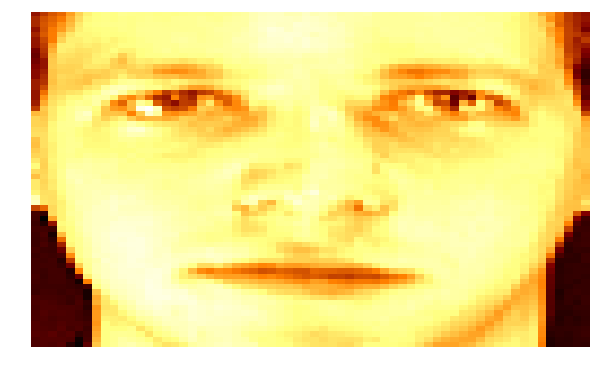

In [9]:
view_as_image(faces[0])

To carry out PCA we will simply use sklearn.decomposition.PCA class for convenience. The mean face and principal components matrix are respectively available as the .mean_ and .components_ attributes of the resultant object. 

In [10]:
pca = sklearn.decomposition.PCA()
pca.fit(faces)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

# Decorrelating Variables

The reason that PCA works as a dimensionality reducer is that it exploits correlations in our input features to use fewer numbers to represent nearly the same relationships between pixels. Consider points on a line $y = mx+b$ if we are lots of pairs of points $x$ and $y$ that follow such a relationship we can simply fit for the slope $m$ and offset $b$ of the data and store only either $x$ or $y$ and use the linear relationship between them to recover the other. We do not usually think of this sort of thing as a dimensionality reduction problem but this is exactly analogous to what we are doing in PCA.

If we make a scatter plot of the intensities of two nearby pixels in our image space we would see that they are strongly correlated to each other. Even two very distant pixels will likely be correlated to each other by virtue of similar lighting conditions but the relationship will in general tend to be weaker. Lets look at the joint distributions of a few pixel pairs.

In [11]:
mean_face = np.mean(faces, axis=0)

def pixel_pair_scatter(row, col, row_delta, col_delta, bg_img=None):
    if bg_img is None:
        bg_img = mean_face
    #find the columns of the pixels in the flattened array
    x1 = row, col
    x2 = (row+row_delta, col+col_delta)
    pix1_idx = np.ravel_multi_index(x1, im_shape)
    pix2_idx = np.ravel_multi_index(x2, im_shape)
    
    fig, axes = plt.subplots(1, 2)
    view_as_image(mean_face, ax=axes[0])
    
    #plot the selected pixel locations over the mean face for context
    axes[0].plot([col, col+row_delta], [row, row+col_delta], c="r", marker="o", linestyle="none")
    
    #plot the intensities at each pixel location against each other
    axes[1].scatter(faces[:, pix1_idx], faces[:, pix2_idx], alpha=0.4, s=60)
    axes[1].set_xlabel("intensity at pixel {}".format(x1))
    axes[1].set_ylabel("intensity at pixel {}".format(x2))

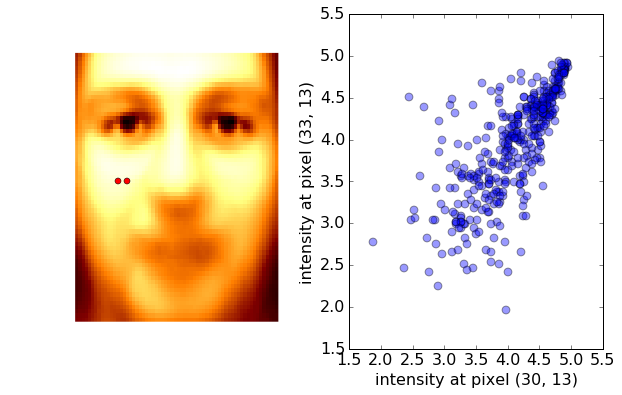

In [12]:
pixel_pair_scatter(30, 13, 3, 0)

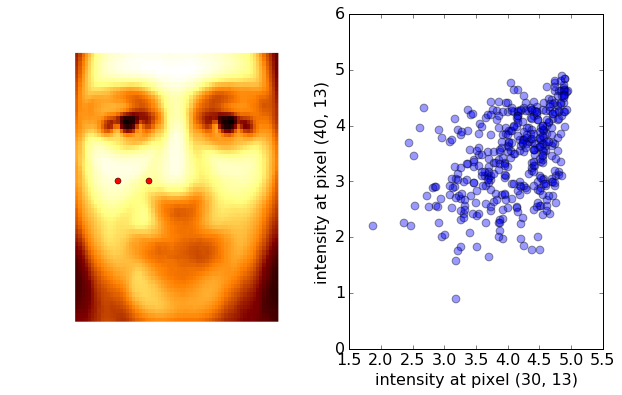

In [13]:
pixel_pair_scatter(30, 13, 10, 0)

Looking at these distributions it is clear that there is a predictive relationship here. One way to quantify the shared information between these two values is in terms of the covariance between them. High covariances indicate strong relationships between pixels and signal that we could stand to gain something by using a representation that takes advantage of this relationship.

Dealing with strongly correlated variables is a pain. Many statistical techniques assume that we are dealing with uncorrelated variables and for related reasons many machine learning algorithms (e.g. Naive Bayes) are drammatically adversely affected by strongly correlated inputs and even techniques which are somewhat robust to correlated variables (e.g. Random Forests) none the less can have their performance significantly improved by using decorrelated features even if we don't reduce the dimensionality of our data at all.

Lets plot the transformed data against each other and verify that they don't exhibit any clear correlations.

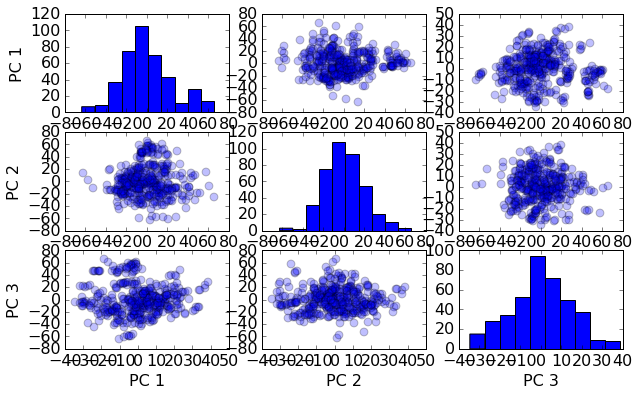

In [14]:
# the projection weights W
transformed = pca.transform(faces)

n_pairs = 3
fig, axes = plt.subplots(n_pairs, n_pairs)

for i in range(n_pairs):
    for j in range(n_pairs):
        if i!=j:
            axes[i, j].scatter(transformed[:, i], transformed[:, j], s=60, alpha=0.25)
        else:
            axes[i, i].hist(transformed[:, i])
            
for i in range(n_pairs):
    axes[-1, i].set_xlabel("PC {}".format(i+1))
    axes[i, 0].set_ylabel("PC {}".format(i+1))

Now our data looks rather a lot like undifferentiated (hopefully Gaussian) blobs. From the perspective of most statistical techniques this is great this is exactly the kind of data that generations of statisticians wrote theorem after theorem about because it is easy to deal with. But all the structure that was present in the original data is still present in this new form but we have simply applied a rotation $H^T$ to flatten out any linear relationships.

# Semantic Factor Discovery

One of the wonderful things about PCA is that every once in a while the shape of the principal vectors gives you an important insight into your data that you otherwise might have missed. Although sometimes important insight is found by looking at the distribution of the data in its transformed state (for example the data falls into distinct clusters that you had missed prior to transformation! Something that is not happening here but that does happen with regularity.) usually the insights are to be found by interrogating the principal vectors. 

Lets visualize the components and see if we can glean anything interesting from them. As you scroll down try and come up with your own interpretations of what potentially could be causing the variations indicated by these vectors. Consider these vectors as incremental changes you might make to one of the images. You may find it helpful to ask yourself "what would adding a little bit of this vector to a face image do?". I will give you my own interpretations at the bottom. 

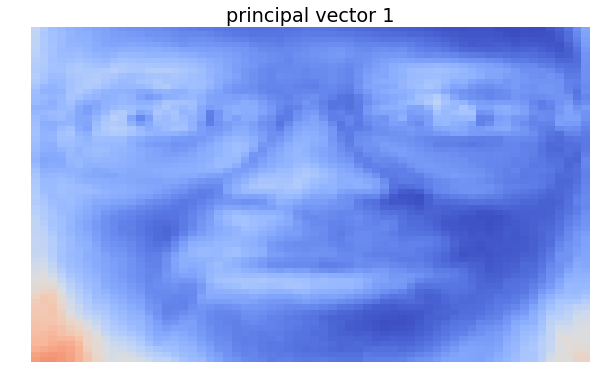

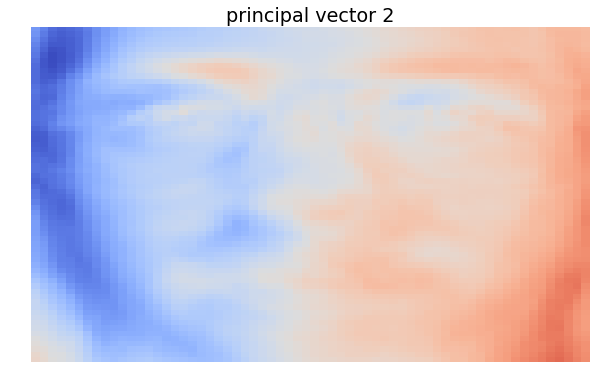

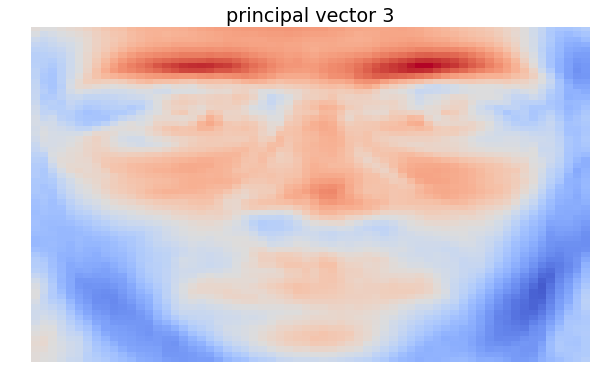

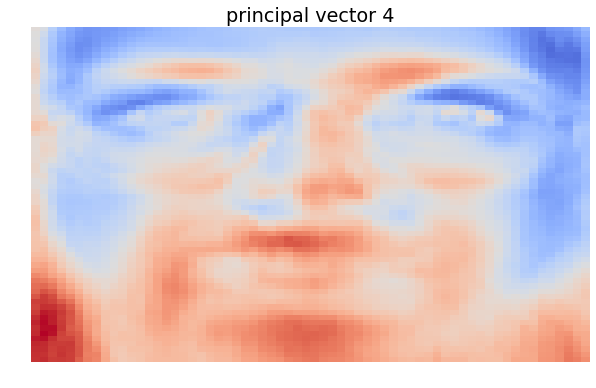

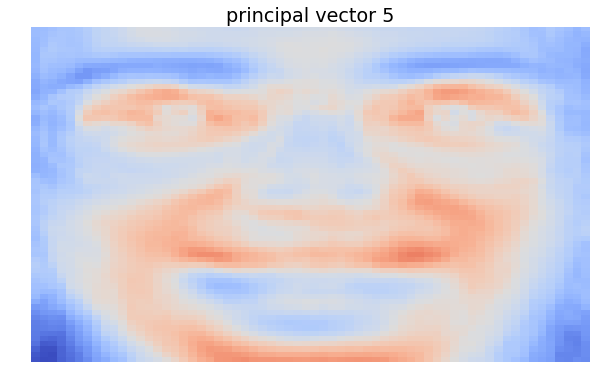

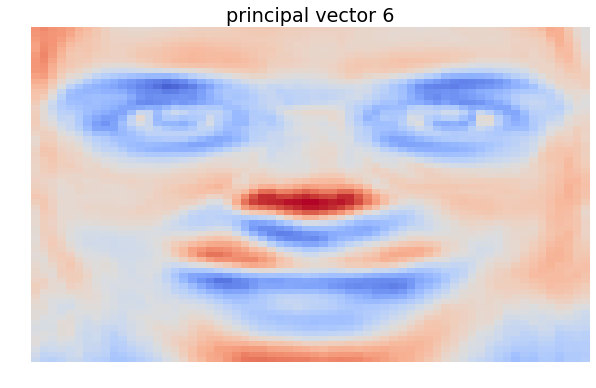

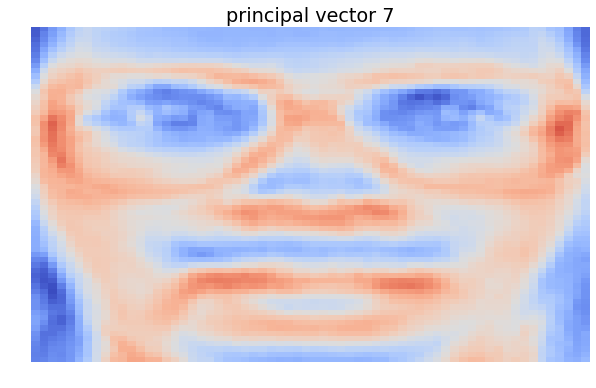

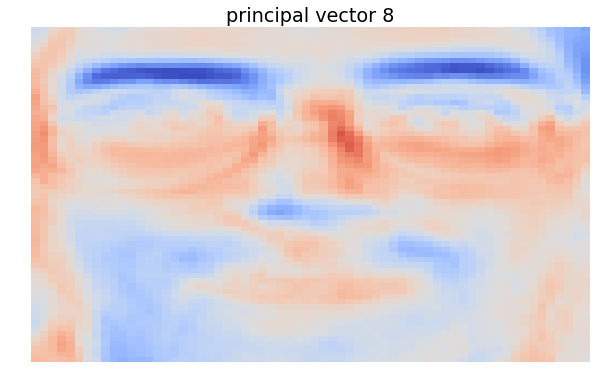

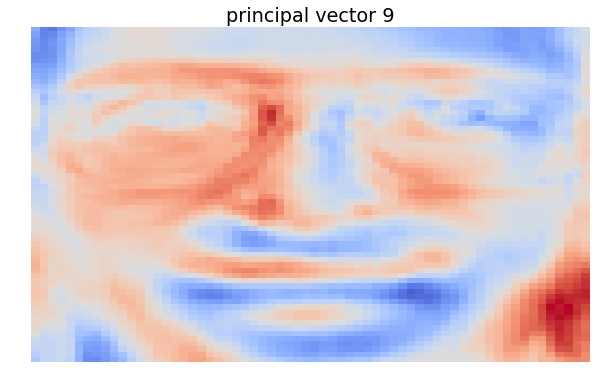

In [15]:
principal_vectors = pca.components_

for i in range(9):
    cvec = principal_vectors[i]
    max_mag = np.max(np.abs(cvec))
    view_as_image(cvec, cmap="coolwarm", vmin=-max_mag, vmax=max_mag)
    plt.title("principal vector {}".format(i+1))
    plt.show()

Principal vector 1 affects most of the face in the same overall sense and so adding or subtracting a little bit of it from an image would tend to change the overall apparent brightness and so this vector is likely related to the ambient lighting conditions and/or skin tone. 

Vectors 2 and 3 and 4 have a kind of di-pole look to them. Vector 2 looks like almost a pure linear shift just shifting the face a little to the left or a little to the right without much affecting its pose. Adding a little of vector 3 looks like it would effectively shift the face a little up or down. Vector 3 however doesn't look quite like a linear shift but looks more like a change in the inclination of the face since the action of vector 3 would strongly change the lightness of just around the eye sockets and on the cheeks but much less strongly affect the heavily shadowed parts of the face this is consistent with the changes in facial shadow that one would expect to come from inclining the head. Likewise vector 4 looks as though it might adjust somewhat for a left right change in pose what we might expect from turning the head a little instead of a simple left right shift as per vector 2.

The components get progressively less clear in terms of interpretation but vectors 5-9 clearly have a strong connection with whether or not the subject is wearing glasses and all the changes to the face that that might entail both including the glasses themselves and changes to shadow and/or different specular reflections off the glass. 


It is important to note that interpreting the "meanings" of principal vectors is a tricky business and there is not really any one "right" interpretation. Since we didn't inject any context in to the generation of the principal vectors we shouldn't expect that they will correspond to humanly meaningful concepts in any real way although sometimes that seems to happen by luck. This is especially tricky as we move to higher and higher principal component numbers since increasingly the interpretation of the actions of these components must be done in light of the previous components. 

Instead of assigning any semantics directly to the principal vectors and/or their associated principal component values I would advise you instead to look to the principal vectors for inspiration. For example the 2nd principal vector above very strongly looks like the change that would occur from a left/right shift of the face this could be a strong indication that our system for centering our faces could be slightly improved to remove these shifts.  

# Empirical Noise Modeling

The data as we have been dealing with it up till now is essentially free of noise. However it is frequently the case in real world applications that the data we are looking at is extremely noisy. Usually we are not given any indication of exactly what sort of noise to expect in our data but instead we must somehow figure this out directly from our data.

One possible answer to the question of how to determine the amount of noise in our data is to use PCA! One classic aspect of PCA that we have not as of yet mentioned is that we can look at the fraction of the data variance which is captured by each of our components. Usually the convention is to look at the cumulative sum of the captured variance. Conveniently there is an attribute of the PCA object called .explained_variance_ which we can use to analyze the amount of data variation due to each component. This is not any different than simply taking the variance of the features after transformation into PCA space.

In [16]:
np.testing.assert_allclose(np.std(transformed, axis=0)**2, pca.explained_variance_, atol=1e-7)

In [17]:
def plot_variance_curve(pca_result, ax=None, cumulative=True, normed=True, **line_kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    
    cvar = pca_result.explained_variance_
    if cumulative:
        cvar = np.cumsum(cvar)
    
    if normed:
        cvar /= np.max(cvar)
    
    x = np.arange(1, len(cvar)+1)
    ax.set_xlabel("principal component #")
    ax.set_ylabel("Captured Variance")
    
    return ax.plot(x, cvar, **line_kwargs)
    

This looks like a classic "good" PCA captured variance plot most of the variation of the input images can be captured in only a small fraction of the total number of dimensions of the input data. One thing you might be thinking is "Hey! there were 4096 pixels in the input how come there are only 400 components?". Well there are only 400 input images in this data set and so 400 components suffices to capture all the structure exactly. We could extend the basis of principal vectors out to be a complete basis of all 4096 dimensions but after the first 400 dimensions there would be no meaning to the way in which we ordered them. 

Although the fraction of captured variance goes to 1 in this plot that is really more an artefact of our limited sample size than anything else. Just as any 2 points fit a line perfectly any 400 points fit a 400 dimensional hyperplane perfectly (doesn't roll off the tongue quite as nicely does it?). Sometimes in regard to PCA you will hear someone say that the principal components "explain" the variance. As evidenced by the fact that the attribute name of the sklearn PCA object is called explained variance. Note that I have chose to call it "captured variance" instead which is much more accurate.

This may seem two faced since just above this I suggested that the principal vectors of PCA were suitable for "semantic factor discovery" and now I seem to be suggesting that they have no meaning at all! what is going on here! It may be a subtle distinction but it is we who give meaning to the results of our analysis not the analysis itself in the case of the facial decomposition that we did above it is clear that it would be posible to interpret the values of some of the principal components are physically suggestive. For example the value of component 2 will correlate to a left right shift of the face and the value of component 7 will correlate with whether or not the person in the image is wearing glasses. However I want to stress again that this was a happy accident and not something intrinsic to the analysis technique itself. It is our interpretation of these vectors that give them their meaning. 

To see that it is an overstep to say that our principal vectors "explain" anything consider what happens when we apply PCA to pure white noise. Because there is no true underlying correlation between our input variables the resultant PCA expansion will be nonsense. By pure happenstance however random statistical fluctuations will make it so that our data appears to have a greater amount of variance in some directions than others. The more dimensions we have the more evenly the variation will be spread out among them all and our captured variance curves will look less and less impressive. To illustrate this effect I have generated some random noise with the same number of samples as our faces dataset in various numbers of dimensions (including our case of 4096) and plotted up the results for comparison.

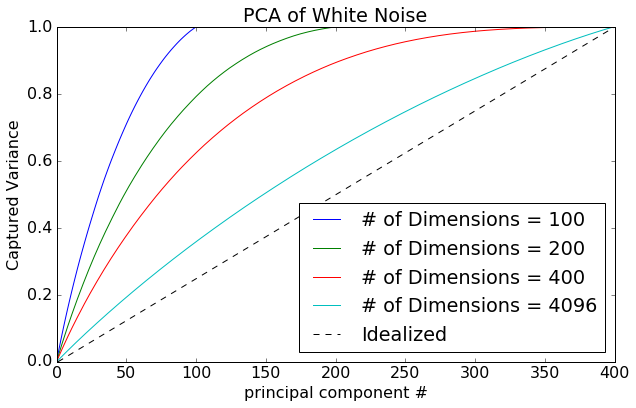

In [18]:
npts = len(faces)

fig, ax = plt.subplots()

for n_dim in [100, 200, 400, 4096]:
    x_random = np.random.normal(size=(npts, n_dim))
    pca_random = sklearn.decomposition.PCA()
    pca_random.fit(x_random)
    
    line ,= plot_variance_curve(pca_random, ax=ax)
    
    line.set_label("# of Dimensions = {}".format(n_dim))

plt.plot([1, npts], [0, 1], linestyle="--", c="k", label="Idealized")
plt.title("PCA of White Noise")
plt.legend(loc="best")

Take Away:

* <b> For small sample sizes and/or small number of dimensions even complete randomness can make a captured variance curve that looks good! </b>

However lets suppose that we are operating in the regime where we are considering only k principal vectors with k << N and/or k << D. In this regime we expect white noise to look essentially like a straight line in the cumulative variance plot. 

Variance is additive whether do to structure in the data (signal) or random statistical fluctuation (noise). Therefore the variance curves that we look at for any given real dataset can be thought of as a sum of a signal variance curve and a noise variance curve. That means that he the analysis of the behavior our the tail end of our variance curve can give us a robust estimate of the amount of noise present in our data. To see how this works lets intentionally inject different amounts of noise into our faces dataset and look closely at what happens to the cumulative variance curves.

In [19]:
signal_to_noise_ratios = [0.5, 1.0, 2.0, 4.0]

noise_realizations = []
noisy_faces = []

for snr_idx, signal_to_noise_ratio in enumerate(signal_to_noise_ratios):
    #generate noise of the right magnitude
    noise = np.random.normal(size=(faces.shape))
    #note that we divided our input data by its standard deviation on input
    # therefore the signal variance is == 1.0
    noise /= signal_to_noise_ratio
    
    #add noise to the data
    noisy_faces.append(faces + noise)
    noise_realizations.append(noise)
    

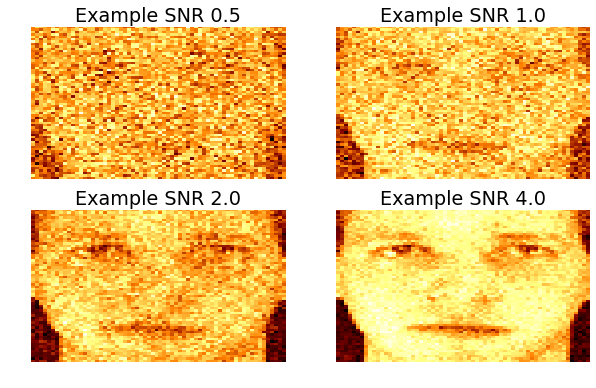

In [20]:
fig, face_axes = plt.subplots(2, 2)
face_axes = face_axes.ravel()

for snr_idx, signal_to_noise_ratio in enumerate(signal_to_noise_ratios):
    label_str = "SNR {}".format(signal_to_noise_ratio)
    
    ax = face_axes[snr_idx]
    view_as_image(noisy_faces[snr_idx][0], ax=ax)
    ax.set_title("Example " + label_str)

looking at the example faces with different amounts of noise injected it is striking how at a signal to noise of 1/2 it is practically impossible to even determine that the image we are looking at has a face at all. While at a signal to noise of 4 the face is already quite dominant. Lets carry out PCA on each noisy dataset and see how things change relative to the noiseless case.

In [21]:
noisy_pcas = [sklearn.decomposition.PCA().fit(noisy_data) for noisy_data in noisy_faces]

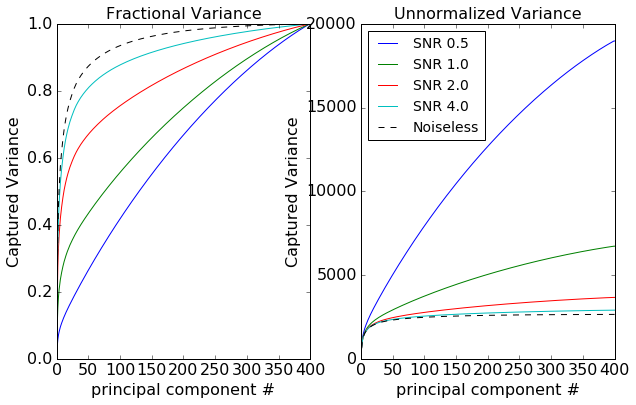

In [22]:
fig, axes = plt.subplots(1, 2)
axes = axes.ravel()

for snr_idx, signal_to_noise_ratio in enumerate(signal_to_noise_ratios):
    label_str = "SNR {}".format(signal_to_noise_ratio)
    
    line ,= plot_variance_curve(noisy_pcas[snr_idx], ax=axes[0], normed=True, cumulative=True)
    line.set_label(label_str)
    
    line ,= plot_variance_curve(noisy_pcas[snr_idx], ax=axes[1], normed=False, cumulative=True)
    line.set_label(label_str)
    
axes[0].set_title("Fractional Variance", fontsize=16)
axes[1].set_title("Unnormalized Variance", fontsize=16)

line ,= plot_variance_curve(pca, ax=axes[0], linestyle="--", c="k", label="Noiseless")
line ,= plot_variance_curve(pca, ax=axes[1], linestyle="--", c="k", label="Noiseless", normed=False)

plt.legend(fontsize=14, loc="best")

Looking at the fractional variance plots as we have been doing up to this point we can see that for the highest signal to noise data the captured variance curve is very similar to the noiseless case for low numbers of principal components and then approaches a slow nearly linear curve which takes us up to 100% of the data variance. However what is really going on here is somewhat masked by normalizing the variance to add up to 1 regardless. 

When we add noise into our dataset we are increasing the total amount of variation present in our data. I can't let this opportunity slip by without giving voice to a small rant;

<b> Variation is NOT the same as information! </b>

I am not completely blameless here. I admit that when I am explaining PCA to someone who has never encountered it before I frequently will use the words "PCA helps you pick out the most informative directions in your data." I do admit that this is a helpful way to think about what PCA is doing. However I want to stress again that the relationshp between variation and information is a purely hueristic one and one should be careful to always keep in mind that PCA is looking at variation it requires a more powerful mind to turn that into information. While this example is slightly contrived (since who wants to intentionally add noise into their data?). This is a perfect example of how variation and information are very different. There is a lot more variation in the lower signal to noise data but there is <i> less </i> information overal. By injecting so much noise into our dataset we have doubtless <i> destroyed </i> some of the information that used to be present! Also I want to head off a common potential mis-understanding you might think that you can partially avoid this problem by moving from looking at covariance between inputs to looking at correlations between inputs. After all perhaps variance isn't information but clearly correlation always signals shared information right? Unfortunately this is emphatically not the case. Moving from covariance to correlation is exactly the same as rescaling each input feature by its variance prior to carrying out PCA (sometimes called whitetening your data). Moving to correlation space does not make your principal components any more meaningful. In fact in this particular case because we have an equal amount of noise variance in every input pixel but the amount of signal variance is dominated by the pixels where there are interesting facial structures whitening actually hurts us. The features which are nearly pure noise are rescaled by $1/\sqrt{noise\_level^2 + 0}$ but interesting pixels with high amounts of variation are rescaled by $1/\sqrt{noise\_level^2 + signal\_variance}$ effectively systematically ignoring our most useful input features! That is not to say that pre-whitening is never the right thing to do. Sometimes you are dealing with data in which your input features have drammatically different scales in such cases something must be done to normalize them and dividing by the column standard deviation is as good a place to start as any. But don't always whiten without first giving it a little thought and especially don't whiten when you are dealing with lots of measurements which are all interpretable on the same scale (e.g. your input features are pixel intensities in an image). OK rant over now back to the task at hand.

Now you might suppose that because the facial structure in the noisier images is only barely perceptible that the principal vectors that its corresponding PCA found would also look essentially like noise (garbage in garbage out as it were). After all if we look at the fractional variance curves it is clear that the amount of variance present in every principal component is dominated by noise variance. Lets look at the principal vectors and see how they look as a function of signal to noise. I have picked the second principal vector because I think it looks rather striking.


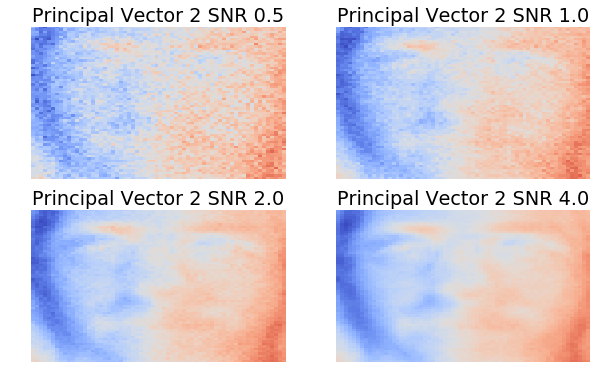

In [23]:
fig, axes = plt.subplots(2, 2)
axes = axes.ravel()

principal_vector_number = 2

for snr_idx, signal_to_noise_ratio in enumerate(signal_to_noise_ratios):
    label_str = "Principal Vector {} SNR {}".format(principal_vector_number, signal_to_noise_ratio)
    
    ax = axes[snr_idx]
    comp = noisy_pcas[snr_idx].components_[principal_vector_number-1]
    mag_max = np.max(np.abs(comp))
    view_as_image(comp, ax=ax, cmap="coolwarm", vmin=-mag_max, vmax=mag_max)
    ax.set_title(label_str)

Even though the noise in the individual images is almost overwhelming for the lower signal to noise images in fact the principal vectors we recover are extremely similar regardless of signal to noise. In retrospect we might have expected this since the noise has no consistency between face image samples and so will get attenuated by having a large number of samples. In this case we have 400 samples and so can roughly speaking expect an increase in signal to noise in our principal vectors of around a factor of $\sqrt{400}=20$. This is somewhat of an overshimplification since the signal variance is not flat for all components but actually drops off very rapidly at higher dimensions. Therefore the higher order principal vectors fare considerably worse.



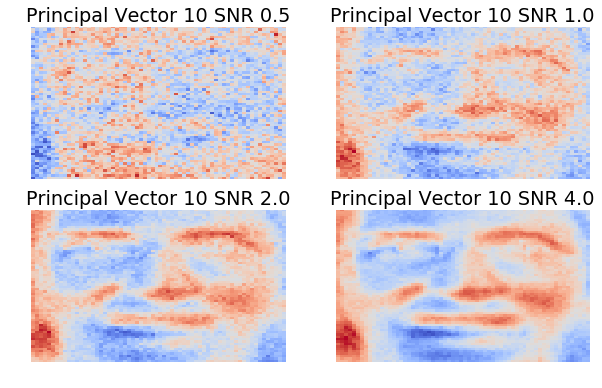

In [24]:
fig, axes = plt.subplots(2, 2)
axes = axes.ravel()

principal_vector_number = 10

for snr_idx, signal_to_noise_ratio in enumerate(signal_to_noise_ratios):
    label_str = "Principal Vector {} SNR {}".format(principal_vector_number, signal_to_noise_ratio)
    
    ax = axes[snr_idx]
    comp = noisy_pcas[snr_idx].components_[principal_vector_number-1]
    mag_max = np.max(np.abs(comp))
    view_as_image(comp, ax=ax, cmap="coolwarm", vmin=-mag_max, vmax=mag_max)
    ax.set_title(label_str)

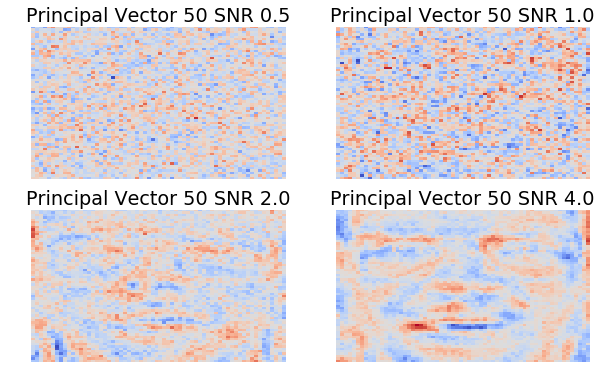

In [25]:
fig, axes = plt.subplots(2, 2)
axes = axes.ravel()

principal_vector_number = 50

for snr_idx, signal_to_noise_ratio in enumerate(signal_to_noise_ratios):
    label_str = "Principal Vector {} SNR {}".format(principal_vector_number, signal_to_noise_ratio)
    
    ax = axes[snr_idx]
    comp = noisy_pcas[snr_idx].components_[principal_vector_number-1]
    mag_max = np.max(np.abs(comp))
    view_as_image(comp, ax=ax, cmap="coolwarm", vmin=-mag_max, vmax=mag_max)
    ax.set_title(label_str)

Now lets return to the variance curves for a moment and remember that ostensibly our goal goal is to empirically determine how much noise is present in our data.
Each of these curves is in fact really just a sum of two curves the signal variance curve (which does not change regardless of the amount of injected noise) and added on to that a noise variance curve which has been scaled by the amount of noise variance we have injected. Variance is the sum of the squared deviations so adding a noise term of magnitude 2 times that of the data (signal to noise = 1/2) will add $2^2=4$ times as much variance as present in the noiseless data. Looking at the unnormalized curves we can in fact see that the total variance present matches our expectations with the variance present in the signal to noise 1/2 data being roughly $1^2 + 2^2$ = 5 times that present in the noiseless data and that present in the signal to noise 1 data is roughly 1^2 + 1^2 = 2 times as much etc etc. Lets make this a little more rigorous and compare the actually observed curves to the sum we are suggesting.

In [26]:
noise_pcas = [sklearn.decomposition.PCA().fit(noise) for noise in noise_realizations]

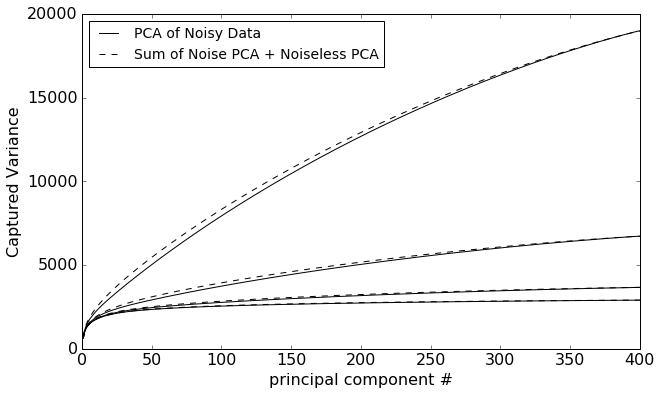

In [27]:
fig, ax = plt.subplots()

for snr_idx, signal_to_noise_ratio in enumerate(signal_to_noise_ratios):
    label_str = "SNR {}".format(signal_to_noise_ratio)
    
    line ,= plot_variance_curve(noisy_pcas[snr_idx], ax=ax, normed=False, cumulative=True, c="k")
    summed_variance = noise_pcas[snr_idx].explained_variance_ + pca.explained_variance_
    sum_line ,= ax.plot(np.arange(1, len(summed_variance)+1), np.cumsum(summed_variance), c="k", linestyle="--")
    
line.set_label("PCA of Noisy Data")
sum_line.set_label("Sum of Noise PCA + Noiseless PCA")
plt.legend(loc="best", fontsize=14)

As you can see the sum of the noise variance alone and the structure based variance we get from doing PCA on the noiseless dataset are very close. The because of the nature of the PCA algorithm it tries to push as much variance as it can into the lower components and even in the case of pure noise it is able to do this a little bit. That is why the sum of the cumulative variance of the PCA of the noise alone + the noiseless PCA tends to be above the curve for the noisy data. When we are taking the PCA of noise and data jointly we have less freedom to overfit and so the captured variance curve is a little flatter since we have to split the difference between capturing noise variance and signal variance. 

I have shown that the PCA captured variance curve is very nearly the sum of a noise only term and a signal only term which is interesting but not particularly useful. Lets put some code where my mouth is and see if we can reverse engineer the signal to noise of the data directly from the variance curves.

Now here unfortunately we are posed with a dillema which is in the strictest sense unsolvable. Namely our data could have any sort of variance structure imaginable such that our cumulative captured variance curves could take the shape of any monotonically increasing curve. Luckily for us however in practice the true underlying signal variance curve tend to look similar to each other even for extremely different types of data. We want to make as few assumptions as possible about the shape of our signal variance curve since those assumptions will bias our findings. However one assumtion that very often turns out to be true in practice is that the underlying signal variance is very low dimensional relative to the total dimensionality of our feature space. In that case that means that the variance captured in the highest order principal components will be almost totally noise dominated. 

To state this more formally we expect that for component index i sufficently high we expect that roughly speaking the projected variance $V_i$ (as opposed to the cumulative variance) should roughly obey the relation,

$$
V_i \approx Noise^2
$$

Annother way of saying the same thing is that the slope of the cumulative captured variance curve should eventually approach a slope which is proporitional to the squared noise magnitude $Noise^2$. In order to turn this into signal to noise ratio we would also need to somehow estimate the signal variance. This is rather a fuzzy concept in real world datasets since there is almost never going to be a clear answer to the question of where the signal components stop and the noise components begin. We will dodge this question for now and simply assert that the "signal" variance of our data is equal to 1 per pixel because we divided it by the global standard deviation of our data as we loaded it in. Obviously in real world data we cannot first normalize on signal only and then add in noise afterwards (wouldn't that be nice?) so deriving a signal to noise may not be possible. However it is really the amount of noise in our data that we should be interested in anyway since it gives a concrete answer to the question "by how much can I expect a given pixel to vary in intensity due to noise alone?" or equivalently "About how much intensity variation can I safely ignore?".

In [32]:
variance_slopes = np.zeros(len(signal_to_noise_ratios))

k_start = 200
k_end =   399

for snr_idx, snr in enumerate(signal_to_noise_ratios):
    cum_var = np.cumsum(noisy_pcas[snr_idx].explained_variance_)[k_start:k_end]
    line_coeffs = np.polyfit(np.arange(np.abs(k_end-k_start)), cum_var, deg=1)
    cslope = line_coeffs[0] #numpy polynomial format is highest power first
    variance_slopes[snr_idx] = cslope

print("True Noise   Predicted Noise")
for true_snr, pred_noise in zip(signal_to_noise_ratios, np.sqrt(variance_slopes)):
    print("{: 5.2f}        {: 5.2f}".format(1.0/true_snr, pred_noise))

True Noise   Predicted Noise
 2.00         5.62
 1.00         2.91
 0.50         1.57
 0.25         0.92


Treating the noise based variance as being completely flat gives us an at least reasonable estimate of the signal to noise of our data but turns out to be an overestimate. We could have guessed this from looking at the pure noise captured variance curves earlier which are all noticeably curvier than straight lines. In particular because our datset has fewer examples than there are dimensions in our feature space we are always guaranteed to get a perfect representation of our data by the last dimension and this tends to anomalously flatten out the captured variance curve as our component number approaches the total number of sample observations. We may be able to improve our estimates a little bit in principle by avoiding the very last few components and instead look a range in the data with a high enough component number to have nearly no signal variance but still far enough away from the number of samples in our dataset to not be too heavily affected by our small sample size.

In [33]:
variance_slopes = np.zeros(len(signal_to_noise_ratios))

k_start = 100
k_end =   250

for snr_idx, snr in enumerate(signal_to_noise_ratios):
    cum_var = np.cumsum(noisy_pcas[snr_idx].explained_variance_)[k_start:k_end]
    line_coeffs = np.polyfit(np.arange(np.abs(k_end-k_start)), cum_var, deg=1)
    cslope = line_coeffs[0] #numpy polynomial format is highest power first
    variance_slopes[snr_idx] = cslope

print("True Noise   Predicted Noise")
for true_snr, pred_noise in zip(signal_to_noise_ratios, np.sqrt(variance_slopes)):
    print("{: 5.2f}        {: 5.2f}".format(1.0/true_snr, pred_noise))

True Noise   Predicted Noise
 2.00         6.68
 1.00         3.48
 0.50         1.93
 0.25         1.25


If your data is small enough that you don't mind running the PCA expansion twice you can do better yet and partially take into account the fact that a purely white noise based PCA curve will differ from a straight line by feeding pure noise with the same shape as your input data through PCA and then doing a linear regression using the pure noise cumulative variance curve as one of the regressors.



In [34]:
variance_slopes = np.zeros(len(signal_to_noise_ratios))

k_start = 150
k_end =   200

noise_pca = sklearn.decomposition.PCA()
noise_pca.fit(np.random.normal(size=faces.shape))
noise_curve = np.cumsum(noise_pca.explained_variance_)

for snr_idx, snr in enumerate(signal_to_noise_ratios):
    cum_var = np.cumsum(noisy_pcas[snr_idx].explained_variance_)[k_start:k_end]
    #line_coeffs = np.polyfit(np.arange(np.abs(k_end-k_start)), cum_var, deg=1)
    fit_matrix = np.stack([noise_curve, np.ones(len(faces))], axis=1)
    fit_matrix = fit_matrix[k_start:k_end]
    line_coeffs = np.linalg.lstsq(fit_matrix, cum_var)[0]
    cslope = line_coeffs[0] 
    variance_slopes[snr_idx] = cslope

print("True Noise   Predicted Noise")
for true_snr, pred_noise in zip(signal_to_noise_ratios, np.sqrt(variance_slopes)):
    print("{: 5.2f}        {: 5.2f}".format(1.0/true_snr, pred_noise))

True Noise   Predicted Noise
 2.00         2.06
 1.00         1.07
 0.50         0.59
 0.25         0.38


However this deviation from a straight line of the PCA expansion of random noise is primarily a small sample size effect. If your dataset is such that the number of samples is much larger than the number of input dimensions the purely linear approximation should suffice. 